# Picture cross solver using Multilayer Neural Network
This jupyter notebook we create an MLP for creating an image or a matrix of zeros and ones using as input an array of tips in the same style as picture cross puzzles.

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import random

We first load the dataset generated by our other jupyter notebook create_dataset.

In [5]:
data_x = np.load("dataset/data_x_4x4.npy")
data_y = np.load("dataset/data_y_4x4.npy")

Then we shuffle the dataset.

In [6]:
shuffle = list(range(len(data_x)))
random.shuffle(shuffle)
data_x = data_x[shuffle]
data_y = data_y[shuffle]

We print the shape of the data_y and data_x.

In [32]:
shape = (4,4)
print(data_y.shape)
print(data_x.shape)

(65536, 4, 4)
(65536, 16)


Our input is normalized by dividing by the max value possible in the array. That is, divided by 4 (from the max size of the 4x4 matrix).

In [8]:
data_x[0]/shape[0]

array([0.33333333, 0.        , 0.33333333, 0.        , 0.66666667,
       0.        , 0.66666667, 0.        , 0.        , 0.        ,
       0.33333333, 0.66666667, 1.        , 0.        , 0.        ,
       0.        ])

Our output is the matrix of zeros and ones. But since we are using a tanh activation we converted the output to -1 and ones.

In [9]:
data_y[0]*2-1

array([[-1,  1, -1, -1],
       [-1, -1,  1, -1],
       [-1,  1,  1, -1],
       [-1,  1,  1, -1]])

This variable set how we are going to split our training and test data. In this example, the split is one. That means that all data is set to be for training. Because we generated our own dataset including all possibilities available to the shape of the matrix, there was no need to use test set since our goal is just to solve the puzzle for the shape 4x4 matrix. If there were a huge amount of data to process as for example a 10x10 matrix then we would split the dataset so that the training would learn the general rules with a low processing cost. In this case, we only wanted to solve the puzzle, there was no need to generalize the network. 

In [10]:
split = 1-0.00

In [11]:
train_x = data_x[:int(len(data_x)*split)]/shape[0]
test_x = data_x[int(len(data_x)*split):]/shape[0]
train_y = data_y[:int(len(data_y)*split)]*2-1
test_y = data_y[int(len(data_y)*split):]*2-1

print(train_x.shape)
print(test_x.shape)

(65536, 16)
(0, 16)


In [12]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.models import Model
from keras.callbacks import TensorBoard

In [13]:
import winsound

We tried to find the best network configuration using all the available activators, optimizers and losses. We tried different combinations using a simple neural network, with only one dense layer of 16 nodes, to find the best available configuration. 

The result of the analysis is in another notebook called statistic. We analyze the output and determined the best configuration.

In [14]:
activations = ["softmax", 
               "elu", 
               "selu", 
               "softplus", 
               "softsign", 
               "relu", 
               "tanh", 
               "sigmoid", 
               "hard_sigmoid", 
               "exponential", 
               "linear"]

In [15]:
optimizers = ["SGD", 
              "RMSprop", 
              "Adagrad", 
              "Adadelta", 
              "Adam", 
              "Adamax", 
              "Nadam"]

In [16]:
losses = ["mean_squared_error", 
          "mean_absolute_error", 
          "mean_absolute_percentage_error", 
          "mean_squared_logarithmic_error", 
          "squared_hinge", 
          "hinge", 
          "categorical_hinge", 
          "logcosh", 
#           "categorical_crossentropy", 
#           "sparse_categorical_crossentropy", 
          "binary_crossentropy", 
          "kullback_leibler_divergence", 
          "poisson", 
          "cosine_proximity"]

After the run of different combinations, we found that nadam optimizers and cosine_proximity performed better for a simple neural network with only one layer of 16 nodes. We then used the same optimizer and loss function to train the MLP. Later on, we changed the activation function to tanh, that performed better than elu in term of accuracy.

After training, we predicted all the training cases and count those that failed. In the end, we had 14591 failed cases. Close enough to the 13174 theoretical cases that would fail.

In [76]:
optimizers = ["Nadam"]
losses = ["cosine_proximity"]
activations = ["elu"]

for i in optimizers:
    for j in losses:
        for l in activations:
            print(i+"&"+j+"&"+l)

            main_input = Input(shape=data_x.shape[1:], name='main_input')
            x = Dense(shape[0]*shape[1]*12, activation="tanh")(main_input)
    #         y = keras.layers.concatenate([x, main_input])
    #         y = Dense(shape[0]*shape[1], activation='tanh')(y)
    #         z = keras.layers.concatenate([y, main_input])
    #         z = Dense(shape[0]*shape[1], activation='tanh')(z)
    #         w = keras.layers.concatenate([z, main_input])
    #         w = Dense(shape[0]*shape[1], activation='tanh')(w)
            x = Dense(shape[0]*shape[1], activation='tanh')(x)
            x = Dense(shape[0]*shape[1], activation='tanh')(x)
            main_output = Reshape(shape, name='main_output')(x)

            model = Model(main_input, main_output)

    #         model.summary()

            model.compile(optimizer=i, loss=j, metrics=['accuracy'])

    #         tensorboard = TensorBoard(log_dir="logs/{}".format(i+"_"+j))

    #         history = model.fit(train_x, train_y, epochs=20, batch_size=1, verbose=0, validation_data=(test_x, test_y), callbacks=[tensorboard])
            history = model.fit(train_x, train_y, epochs=12800, batch_size=320, verbose=0, validation_data=(test_x, test_y))

            count = 0
            for k in range(len(train_x)):
            #     print(i)
            #     print(data_x[i])
                x = train_x[k].reshape((1,-1))
                pred = model.predict(x)
                y = train_y[k]
                if np.array_equal(np.round((pred+1)/2)[0],(y+1)/2) == False:
            #         print(i)
            #         print((y+1)/2)
            #         print(np.round((pred+1)/2)[0])
                    count+=1
            print(count)

Nadam&cosine_proximity&elu
14591


After training we use a beep sound to notify.

In [77]:
duration = 1000  # millisecond
freq = 440  # Hz
winsound.Beep(freq, duration)

We plot the history, showing that the model continued to learn up to 12000 epochs but it did not show any sign of improvement in accuracy after that. 

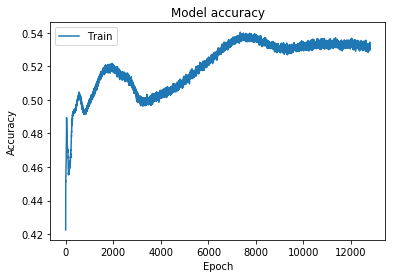

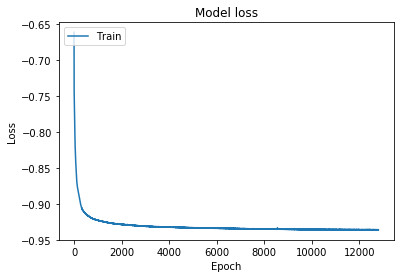

In [78]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We save the model.

In [79]:
model.save("model_4x4_2.h5")

We print all the cases that fail to check if there are ambiguity.

In [99]:
# for i in range(len(data_x)):
count = 0
for i in range(len(train_x)):
#     print(i)
#     print(data_x[i])
    x = train_x[i].reshape((1,-1))
    pred = model.predict(x)
    y = train_y[i]
    if np.array_equal(np.round((pred+1)/2)[0],(y+1)/2) == False:
        print(i)
        print((y+1)/2)
        print(np.round((pred+1)/2)[0])
        count+=1
print(count)

6
[[0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
8
[[0. 1. 1.]
 [0. 0. 0.]
 [1. 0. 0.]]
[[1. 1. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
13
[[0. 0. 1.]
 [0. 0. 0.]
 [1. 1. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]
16
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
17
[[0. 1. 1.]
 [0. 1. 1.]
 [1. 1. 0.]]
[[0. 1. 1.]
 [0. 1. 1.]
 [0. 1. 1.]]
20
[[1. 1. 1.]
 [0. 1. 0.]
 [1. 1. 0.]]
[[1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]]
24
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
27
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
35
[[1. 1. 0.]
 [1. 1. 1.]
 [0. 0. 1.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [0. 0. 0.]]
36
[[1. 1. 0.]
 [0. 1. 1.]
 [0. 0. 1.]]
[[0. 1. 1.]
 [0. 1. 1.]
 [0. 0. 0.]]
41
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
43
[[1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 1.]]
[[0. 0. 1.]
 [1. 1. 1.]
 [0. 0. 1.]]
54
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]]
[[0. 0. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
5

423
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 1.]]
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 1. 1.]]
426
[[0. 0. 0.]
 [0. 0. 1.]
 [1. 1. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [1. 1. 1.]]
427
[[1. 0. 0.]
 [1. 1. 1.]
 [0. 1. 1.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]]
428
[[1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 1.]]
[[1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]]
429
[[1. 0. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]
[[0. 0. 0.]
 [1. 0. 1.]
 [0. 0. 0.]]
440
[[1. 1. 1.]
 [1. 1. 1.]
 [0. 1. 0.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [0. 0. 0.]]
452
[[1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]]
[[1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]]
455
[[0. 0. 1.]
 [1. 1. 1.]
 [1. 1. 0.]]
[[0. 0. 0.]
 [1. 1. 1.]
 [1. 1. 1.]]
456
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
460
[[0. 1. 1.]
 [1. 1. 0.]
 [1. 0. 0.]]
[[1. 1. 0.]
 [1. 1. 0.]
 [0. 0. 0.]]
464
[[0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]]
466
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
469
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]
[[0. 0. 0.]
 [0. 0. 0.]